# LDA

#### Запускать блокнот через 'python -m jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10'

In [1]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import re
import os
import numpy as np
import pandas as pd
from pprint import pprint
from docx.api import Document
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from natasha import Doc, Segmenter

# Gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
# for 'red_txt' method
%run ../rfej_preprocessing/find_shortenings.ipynb

In [4]:
# Путь к файлам с аннотациями
PATH = os.path.abspath('..\\rfej_parser\\articles\\') + '\\'

In [5]:
# sort file names
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [6]:
def text_to_sentances() -> list:
    """Split all .txt files to sentances."""
    files = [fname for fname in glob.glob(PATH + "*") if re.match(f".*\\d+.txt$", fname)]
#     files = [f for f in glob.glob(PATH + '*_a.txt')]
    files.sort(key=natural_keys)
    artcls_sentncs = []
    for f in files:
        artcls_sentncs.append(read_txt(f))
    return artcls_sentncs

In [7]:
docs = text_to_sentances()

In [8]:
def tokenizer(title: str) -> list:
    # Split sentance into tokens and return list.
#     candidate_pos = ['NOUN', 'ADJF', 'VERB']
    candidate_pos = ['NOUN']  # Only nouns
    words_of_sentance = []
    doc = Doc(str(title))
    doc.segment(Segmenter())  # Разбиваем на токены (слова)
    words_raw = [word.text for word in doc.tokens]
    for w in words_raw:
        if morph.parse(w)[0].tag.POS in candidate_pos and w not in stopwords: # or str(morph.parse(w)[0].tag) == 'LATN':  
            final_word = morph.parse(w)[0].normal_form  # Привести к начальной форме
            # Убрать мусор в 1 символ
            if len(final_word):
                words_of_sentance.append(final_word) 
    return words_of_sentance

In [9]:
# Если необходмо добавить стоп-слова: файл `stopwords.txt`
stopwords = set(w.rstrip() for w in open('stopwords.txt', encoding='utf-8'))

In [10]:
# NUMBER OF TEXTES TO USE IN LDA MODEL
NUMB_TXT = 1024
data_words = []
for article in docs[:NUMB_TXT]:
    data_words.append(tokenizer(article))

In [11]:
#TF-IDF HERE

In [12]:
# # Build the bigram and trigram models

# bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10.0) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# # Faster way to get a sentence clubbed as a trigram/bigram

# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
# See trigram example
# print(trigram_mod[bigram_mod[data_words[10]]])

In [14]:
# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]
# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [15]:
# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words)

---

In [16]:
data_words_bigrams = data_words

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

In [18]:
# Create Corpus
texts = data_words_bigrams

In [19]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
def tfidf(matrix):
        td = matrix
        tf = td / td.sum(axis=0)
        idf = np.log(td.shape[1] / np.count_nonzero(td, axis=1)).reshape(-1, 1)
        matrix = tf * idf
        return matrix

In [21]:
# List -> matrix
def list_to_matrix(corpus, id2word, docs) -> np.ndarray:
    """Convert list of corpus to matrix for normalization."""
    # Dict word -> texts with this word
    wdict = {}
    i = -1
    for doc in docs:
        i += 1
        for word in doc:
            if id2word.token2id.get(word) in wdict:
                wdict[id2word.token2id.get(word)].append(i)
            else:                      
                wdict[id2word.token2id.get(word)] = [i]
    # создаём пустую матрицу
    A = np.zeros([len(id2word), len(corpus)])  # y - words, x - texts
    # наполняем эту матрицу
    for i, k in enumerate(sorted(id2word.cfs.keys())):
        for d in wdict[k]:
            A[i,d] += 1
    return A

In [22]:
def get_avg_threshhold(matrix):
    """Get average threshhold for words in matrix."""
    summ = cnt = 0
    for word in matrix:
        for frequency in word:
            if frequency > 0:
                summ += frequency
                cnt += 1
    threshhold = summ / cnt
    return threshhold

In [23]:
import copy

def get_words_with_threshhold(matrix, threshhold, id2word, texts):
    texts_cp = copy.deepcopy(texts)
    for word_nb, word in enumerate(matrix):
        for txt_nb, freq in enumerate(word):
            if freq < threshhold:
                texts_cp[txt_nb] = list(filter(lambda a: a != id2word[word_nb], texts_cp[txt_nb]))
    return texts_cp

In [24]:
#TF-IDF normalization
matrix = list_to_matrix(corpus, id2word, texts)
matrix_tfidf = tfidf(matrix)

In [25]:
threshhold = get_avg_threshhold(matrix_tfidf)

In [26]:
normalized_texts = get_words_with_threshhold(matrix_tfidf, threshhold, id2word, texts)

In [27]:
id2word = corpora.Dictionary(normalized_texts)

In [28]:
texts = normalized_texts

In [29]:
corpus = [id2word.doc2bow(text) for text in texts]

In [30]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

In [31]:
# Number of topics in LDA model
TOPICS_NB = 14

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=TOPICS_NB,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### Metrics of model LDA

In [33]:
def compute_lda_metrics_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence & perplexity for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity_list: perplexity values
    """
    coherence_values = []
    model_list = []
    perplexity_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus, 
            id2word=id2word, 
            num_topics=num_topics, 
            random_state=100, 
            update_every=1, 
            chunksize=100, 
            passes=10,alpha='auto', 
            per_word_topics=True
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_list.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_list

In [34]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

Perplexity:  -9.30570568711295


In [35]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5593886529127804


In [36]:
# Can take a long time to run.
model_list, coherence_values, perplexity_list = compute_lda_metrics_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=100, step=6)

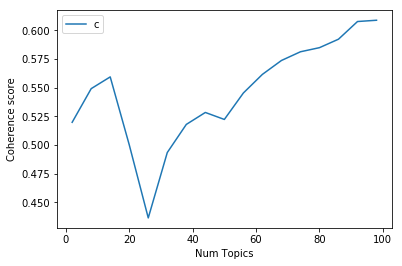

In [37]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
# # Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

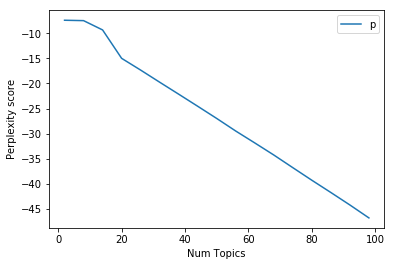

In [39]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, perplexity_list)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_list"), loc='best')
plt.show()

---

## LDA model vis

In [40]:
pyLDAvis.enable_notebook()

In [41]:
vis = pyLDAvis.gensim.prepare(
    lda_model,
    corpus,
    id2word,
    R=lda_model.num_terms,  # The number of terms to display in the barcharts of the visualization
)

In [42]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      10.413870        1       1 -0.122289  0.301618
11      9.955235        1       2  0.008276 -0.236546
2       8.909337        1       3  0.392915  0.099068
10      7.811897        1       4 -0.022685  0.009730
0       7.437788        1       5 -0.038734  0.016569
12      7.320104        1       6 -0.034168 -0.045833
7       7.206598        1       7  0.006336 -0.089631
9       7.132407        1       8 -0.028868 -0.044040
13      7.040560        1       9 -0.049155  0.049463
3       5.844538        1      10 -0.030471 -0.029044
5       5.750139        1      11 -0.027804 -0.021990
4       5.534098        1      12  0.013339 -0.012566
8       5.237575        1      13 -0.040376  0.021575
1       4.405853        1      14 -0.026315 -0.018374, topic_info=                Term        Freq       Total Category    logprob    loglift
term                                                                       
151           услуга  219.000000  219.000000  Default  2725.0000  2725.0000
395         торговля  170.000000  170.000000  Default  2724.0000  2724.0000
149            рынок  184.000000  184.000000  Default  2723.0000  2723.0000
341              сша  161.000000  161.000000  Default  2722.0000  2722.0000
321          экспорт  128.000000  128.000000  Default  2721.0000  2721.0000
674     деятельность  128.000000  128.000000  Default  2720.0000  2720.0000
705              вто  146.000000  146.000000  Default  2719.0000  2719.0000
549        стратегия  114.000000  114.000000  Default  2718.0000  2718.0000
1741          россия   98.000000   98.000000  Default  2717.0000  2717.0000
293            товар  123.000000  123.000000  Default  2716.0000  2716.0000
424         компания  104.000000  104.000000  Default  2715.0000  2715.0000
599        продукция   87.000000   87.000000  Default  2714.0000  2714.0000
330           валюта   96.000000   96.000000  Default  2713.0000  2713.0000
644               ес   95.000000   95.000000  Default  2712.0000  2712.0000
1076            банк   90.000000   90.000000  Default  2711.0000  2711.0000
224           регион   81.000000   81.000000  Default  2710.0000  2710.0000
686              год   66.000000   66.000000  Default  2709.0000  2709.0000
523   сотрудничество   77.000000   77.000000  Default  2708.0000  2708.0000
319       технология   79.000000   79.000000  Default  2707.0000  2707.0000
657      организация   84.000000   84.000000  Default  2706.0000  2706.0000
281       соглашение   70.000000   70.000000  Default  2705.0000  2705.0000
259             опыт   67.000000   67.000000  Default  2704.0000  2704.0000
278           вопрос   70.000000   70.000000  Default  2703.0000  2703.0000
91              союз   83.000000   83.000000  Default  2702.0000  2702.0000
276       управление   69.000000   69.000000  Default  2701.0000  2701.0000
1252        документ   62.000000   62.000000  Default  2700.0000  2700.0000
361        федерация   58.000000   58.000000  Default  2699.0000  2699.0000
338            право   66.000000   66.000000  Default  2698.0000  2698.0000
282          участие   63.000000   63.000000  Default  2697.0000  2697.0000
855    использование   64.000000   64.000000  Default  2696.0000  2696.0000
...              ...         ...         ...      ...        ...        ...
855    использование    0.062368   64.886688  Topic14    -9.4449    -3.8251
338            право    0.062368   66.856246  Topic14    -9.4449    -3.8550
527       кооперация    0.062368   67.173300  Topic14    -9.4449    -3.8597
259             опыт    0.062368   67.221767  Topic14    -9.4449    -3.8605
679          отрасль    0.062368   69.018628  Topic14    -9.4449    -3.8868
276       управление    0.062368   69.843690  Topic14    -9.4449    -3.8987
278           вопрос    0.062368   70.142680  Topic14    -9.4449    -3.9030
281       соглашение    0.062368   70.237377  Topic14

## Dominant topic in text

In [43]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = (sorted(row[0], key=lambda x: (x[1]), reverse=True))
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [44]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
NB_OF_TXT = 10  # Number of texts to show
df_dominant_topic.head(NB_OF_TXT)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            10.0              0.4656   
1            1            13.0              0.6701   
2            2            13.0              0.6664   
3            3             0.0              0.3118   
4            4             2.0              0.7453   
5            5             7.0              0.8260   
6            6             0.0              0.4312   
7            7            13.0              0.3989   
8            8             3.0              0.3824   
9            9            13.0              0.3201   

                                            Keywords  \
0  услуга, технология, право, использование, инве...   
1  еаэс, проект, регулирование, обмен, промышленн...   
2  еаэс, проект, регулирование, обмен, промышленн...   
3  деятельность, процесс, присоединение, г, предп...   
4  сша, валюта, банк, организация, кооперация, со...   
5  стратегия, регион, сотрудничество, политика, с...   
6  деятельность, процесс, присоединение, г, предп...   
7  еаэс, проект, регулирование, обмен, промышленн...   
8  эффективность, показатель, связь, рф, труд, бе...   
9  еаэс, проект, регулирование, обмен, промышленн...   

                                                Text  
0  В статье рассматривается долгосрочная динамика...  
1  Статья рассматривает текущую практику расширен...  
2  В мировой практике в целом, и практике ЕАЭС в ...  
3  Заключение контракта на поставку товаров и усл...  
4  Происходящая сейчас масштабная трансформация г...  
5  Региональным проектом, способным оказать сущес...  
6  Статья посвящена проблемам определения деклара...  
7  В работе проведен анализ сложившейся в практик...  
8  В статье рассматривается важнейшее направление...  
9  В статье исследуются основные причины современ...